In [2]:
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

import torch.nn.functional as F

import timm

import wandb

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

batch_size  = 32
random_seed = 555
random.seed(random_seed)
torch.manual_seed(random_seed)

In [4]:
## make dataset
from torchvision import transforms, datasets
data_path = '/home/jun/Aris_Classification_Project/DataSet/Final_Data/'  # class 별 폴더로 나누어진걸 확 가져와서 라벨도 달아준다
aris_dataset = datasets.ImageFolder(
                                data_path,
                                transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                ]))
## data split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
train_idx, tmp_idx = train_test_split(list(range(len(aris_dataset))), test_size=0.4, random_state=random_seed)
datasets = {}
datasets['train'] = Subset(aris_dataset, train_idx)
tmp_dataset       = Subset(aris_dataset, tmp_idx)

val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.5, random_state=random_seed)
datasets['valid'] = Subset(tmp_dataset, val_idx)
datasets['test']  = Subset(tmp_dataset, test_idx)

## data loader 선언
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=4)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
dataloaders['test']  = torch.utils.data.DataLoader(datasets['test'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  tvt : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 32,  tvt : 212 / 71 / 71


In [31]:
# train 데이터셋의 클래스 불균형을 해결하기 위해 각 클래스별 가중치를 계산

class_weights = [1.0] * 10
for i in range(10):
    class_weights[i] = 1.0 / np.sum(aris_dataset.targets == i)
print(class_weights)

# 가중치를 적용한 cross entropy loss를 계산하는 함수를 정의

def get_weighted_loss(weights):
    def weighted_loss(logits, targets):
        targets = torch.squeeze(targets)
        loss = nn.CrossEntropyLoss(weight=weights.to(device), reduction='mean')
        return loss(logits, targets)
    return weighted_loss

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]


/tmp/ipykernel_510161/71937359.py:5: RuntimeWarning: divide by zero encountered in divide
  class_weights[i] = 1.0 / np.sum(aris_dataset.targets == i)


In [4]:
def print_stats(dataset):
    imgs = np.array([img.numpy() for img, _ in dataset])
    print(f'shape: {imgs.shape}')
    
    min_r = np.min(imgs, axis=(2, 3))[:, 0].min()
    min_g = np.min(imgs, axis=(2, 3))[:, 1].min()
    min_b = np.min(imgs, axis=(2, 3))[:, 2].min()

    max_r = np.max(imgs, axis=(2, 3))[:, 0].max()
    max_g = np.max(imgs, axis=(2, 3))[:, 1].max()
    max_b = np.max(imgs, axis=(2, 3))[:, 2].max()

    mean_r = np.mean(imgs, axis=(2, 3))[:, 0].mean()
    mean_g = np.mean(imgs, axis=(2, 3))[:, 1].mean()
    mean_b = np.mean(imgs, axis=(2, 3))[:, 2].mean()

    std_r = np.std(imgs, axis=(2, 3))[:, 0].std()
    std_g = np.std(imgs, axis=(2, 3))[:, 1].std()
    std_b = np.std(imgs, axis=(2, 3))[:, 2].std()
    
    print(f'min: {min_r, min_g, min_b}')
    print(f'max: {max_r, max_g, max_b}')
    print(f'mean: {mean_r, mean_g, mean_b}')
    print(f'std: {std_r, std_g, std_b}')

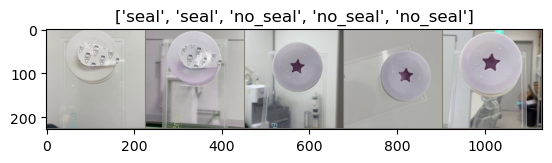

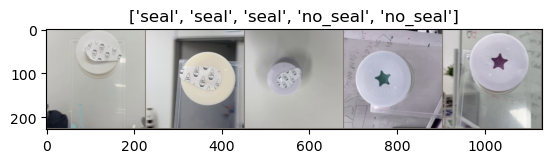

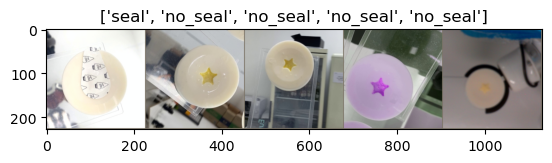

In [4]:
## 데이타 체크
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

num_show_img = 5

class_names = {
    '0' : 'no_seal',
    '1' : 'seal'
}

# train check
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# valid check
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# test check
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                # labels = labels.to(device)

                labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=2)
                labels_one_hot = labels_one_hot.type(torch.FloatTensor).to(device)
    


                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # loss = criterion(outputs, labels)
                    loss = criterion(outputs, labels_one_hot)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
           
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

            # last epoch model save
            if epoch == num_epochs-1:
                torch.save(model.state_dict(), model_name + 'total_last_customfocal_2.pt')
                print('last epoch model saved')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), model_name + 'total_best_customfocal_2.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [17]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class FocalLoss(nn.Module):
#   def __init__(self, gamma=0, alpha=None, size_average=True, device='cpu'):
#     super(FocalLoss, self).__init__()
#     self.gamma = gamma
#     self.alpha = alpha
#     self.size_average = size_average
#     self.device = device

#   """
#   input : N * C (btach_size, num_class)
#   target : N (batch_size)
#   """
#   def forward(self, input, target):
#     CE = F.cross_entropy(input, target, reduction='none')  # -log(pt)
#     pt = torch.exp(-CE)  # pt
#     loss = (1 - pt) ** self.gamma * CE  # -(1-pt)^rlog(pt)
     
#     if self.alpha is not None:
#         alpha = torch.tensor(self.alpha, dtype=torch.float).to(self.device)
    
#         if len(self.alpha) != len(torch.unique(target)): # 3 != 2
#             temp = torch.zeros(len(self.alpha)).to(self.device) # temp = [0, 0, 0]
#             # alpha = [0.1, 0.7, 0.2]
#             # target = [0, 1] After unique
#             temp[torch.unique(target)] = alpha.index_select(0, torch.unique(target))
#             # temp = [0.1, 0.7, 0.0]
#             alpha_t = temp.gather(0, target) #  target에 있는 숫자를 temp로 교환.
#                 # alpha_t = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.7, 0.7, 0.7, 0.7]
#             loss = alpha_t * loss
#         else:
#             alpha_t = alpha.gather(0, target)
#             loss = alpha_t * loss

#         if self.size_average:
#             loss = torch.mean(loss)

#         return loss

In [16]:
#PyTorch
ALPHA = 0.8
GAMMA = 2

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

In [22]:
import torch
import torch.nn.functional as F

from torch.utils import _log_api_usage_once


def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = 0.25,
    gamma: float = 2,
    reduction: str = "none",
) -> torch.Tensor:
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.

    Args:
        inputs (Tensor): A float tensor of arbitrary shape.
                The predictions for each example.
        targets (Tensor): A float tensor with the same shape as inputs. Stores the binary
                classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha (float): Weighting factor in range (0,1) to balance
                positive vs negative examples or -1 for ignore. Default: ``0.25``.
        gamma (float): Exponent of the modulating factor (1 - p_t) to
                balance easy vs hard examples. Default: ``2``.
        reduction (string): ``'none'`` | ``'mean'`` | ``'sum'``
                ``'none'``: No reduction will be applied to the output.
                ``'mean'``: The output will be averaged.
                ``'sum'``: The output will be summed. Default: ``'none'``.
    Returns:
        Loss tensor with the reduction option applied.
    """
    # Original implementation from https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py

    if not torch.jit.is_scripting() and not torch.jit.is_tracing():
        _log_api_usage_once(sigmoid_focal_loss)
    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    # Check reduction option and return loss accordingly
    if reduction == "none":
        pass
    elif reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()
    else:
        raise ValueError(
            f"Invalid Value for arg 'reduction': '{reduction} \n Supported reduction modes: 'none', 'mean', 'sum'"
        )
    return loss

ImportError: cannot import name '_log_api_usage_once' from 'torch.utils' (/home/jun/anaconda3/envs/Detection/lib/python3.10/site-packages/torch/utils/__init__.py)

In [5]:
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()
 
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps
 
    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """
 
        # Calculating Probabilities
        x_sigmoid = torch.sigmoid(x)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid
 
        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)
 
        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg
 
        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w
 
        return -loss.sum()

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=3, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=-1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class CustomFocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, beta=0.8, size_average=True):
        super(CustomFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta  # Precision 조절을 위한 추가 매개변수
        if isinstance(alpha, (float, int)):
            self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list):
            self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)  # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))  # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = F.log_softmax(input, dim=-1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * Variable(at)

        # Precision 조절을 위한 추가 항
        precision_factor = 1 / (pt + self.beta)

        loss = -1 * (1 - pt) ** self.gamma * precision_factor * logpt
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()


In [9]:
class PrecisionFocalLoss(nn.Module):
    def __init__(self, gamma=None, alpha=None, beta=None, size_average=True):
        super(PrecisionFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta  # Precision 조절을 위한 추가 매개변수 (list로 변경)
        if isinstance(alpha, (float, int)):
            self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list):
            self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)  # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))  # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = F.log_softmax(input, dim=-1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * Variable(at)

        # Precision 조절을 위한 추가 항 (클래스별 beta 사용)
        precision_factor = torch.gather(torch.tensor([1 / (pt + beta) for beta in self.beta]), 0, target)

        loss = -1 * (1 - pt) ** self.gamma * precision_factor * logpt
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()


In [ ]:
def loss_function(y_true, y_pred):
    # seal을 no_seal로 잘못 판단하는 경우의 cost
    loss_seal_no_seal = F.binary_cross_entropy(y_true, y_pred, from_logits=True) * 10
    # no_seal을 seal로 잘못 판단하는 경우의 cost
    loss_no_seal_seal = F.binary_cross_entropy(y_true, y_pred, from_logits=True)
    # seal을 no_seal로 잘못 판단하는 경우의 cost를 크게 설정
    loss = loss_seal_no_seal + loss_no_seal_seal
    return loss

In [21]:
num_classes_0 = 70001
num_classes_1 = 4264

total_samples = num_classes_0 + num_classes_1

weight_for_class_0 = total_samples / (num_classes_0 * 2)
weight_for_class_1 = total_samples / (num_classes_1 * 2)

print("Weight for class 0: {:.2f}".format(weight_for_class_0))
print("Weight for class 1: {:.2f}".format(weight_for_class_1))

Weight for class 0: 0.53
Weight for class 1: 8.71


In [26]:
weight = torch.tensor([weight_for_class_0, weight_for_class_1])
# criterion = nn.BCEWithLogitsLoss(pos_weight=weight)

In [27]:
criterion = nn.CrossEntropyLoss(weight=weight)

In [2]:
import torch

target = torch.ones([10, 64], dtype=torch.float32)
output = torch.full([10, 64], 1.5) # 1.5로 채워진 10x64 행렬

pos_weight = torch.ones([32], 2) # 길이 64를 1로 채움
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=5)
criterion(output, target)

tensor(0.2014)

In [2]:
target = torch.ones([32,2], dtype=torch.float32)
output = torch.full([32,2], 1.5)

pos_weight = torch.ones([32], 2)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

TypeError: ones() received an invalid combination of arguments - got (list, int), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [18]:
# no_seal의 경우는 0.8, seal의 경우는 5의 가중치를 주는 pos_weight를 설정
pos_weight = torch.ones([32,2])
pos_weight[0] = 0.8
pos_weight[1] = 5
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [20]:
# 배치사이즈 32, 클래스 수 2에 맞는 pos_weight 모양 정의
pos_weight = torch.ones([32,2], dtype=torch.float32)
# pos_weight 출력
print(pos_weight)

# 클래스 1에 대한 pos_weight를 3으로 설정, 클래스 0에 대한 pos_weight는 0.7로 설정
pos_weight[:, 1] = 3
pos_weight[:, 0] = 0.7

print(pos_weight)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])
tensor([[0.7000, 3.0000],
        [0.7000, 3.0000],
        [0.7000, 3.0000],
        [0.7000, 3.0000],
        [0.7000, 3.0000],
        [0.7000, 3.0000],
        [0.7000, 3.0000],
        [0.7000, 3.0000],
        [0.7000, 3.0000],
        [0.7000, 3.0000],
        [0.7000, 3.0000],
        [0.7000, 3.0000],
        [0.7000, 3.0000],
        [0.7000, 3.0000],
        [0.7000, 3.0000],
        [0.7000, 3.0000],
       

In [12]:
# wandb.init(project="aris", name="fastvit_t8_total_data")

num_classes = 2

model_name = 'fastvit_t8'

model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu
model = model.to(device)

pos_weight = torch.tensor([0.7, 3])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


optimizer_ft = optim.Adam(model.parameters(), 
                         lr = 0.000005,
                         weight_decay=1e-6)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer_ft, max_lr=0.000005, steps_per_epoch=len(dataloaders['train']), epochs=100, pct_start=0.1, div_factor=10, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, last_epoch=-1, verbose=False)

model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, 
        criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

# # best model save
# torch.save(model.state_dict(), model_name+'_total_data.pt')
# print('model saved')

# wandb.log({"train_loss": train_loss, 
#            "train_acc": train_acc,
#            "val_loss": valid_loss,
#            "val_acc": valid_acc}) 
           
# wandb.watch(model)

Epoch 0/9
----------


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

best model : 44 - 100 / 0.0


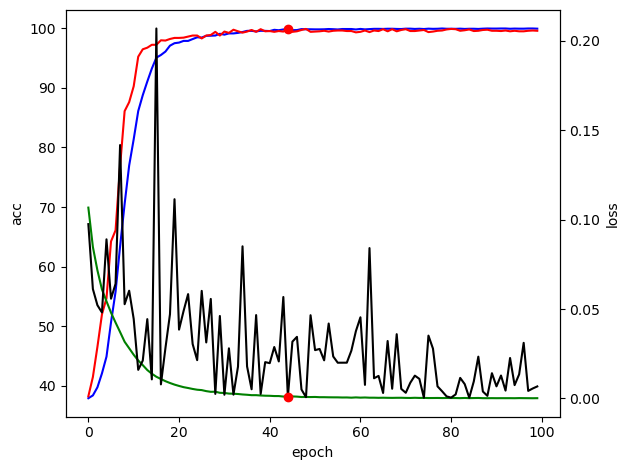

In [13]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

Accuracy of the network on the 2253 test images: 99 %
Accuracy of no_seal : 99 %
Accuracy of  seal : 99 %
[[1412    1]
 [   6  834]]


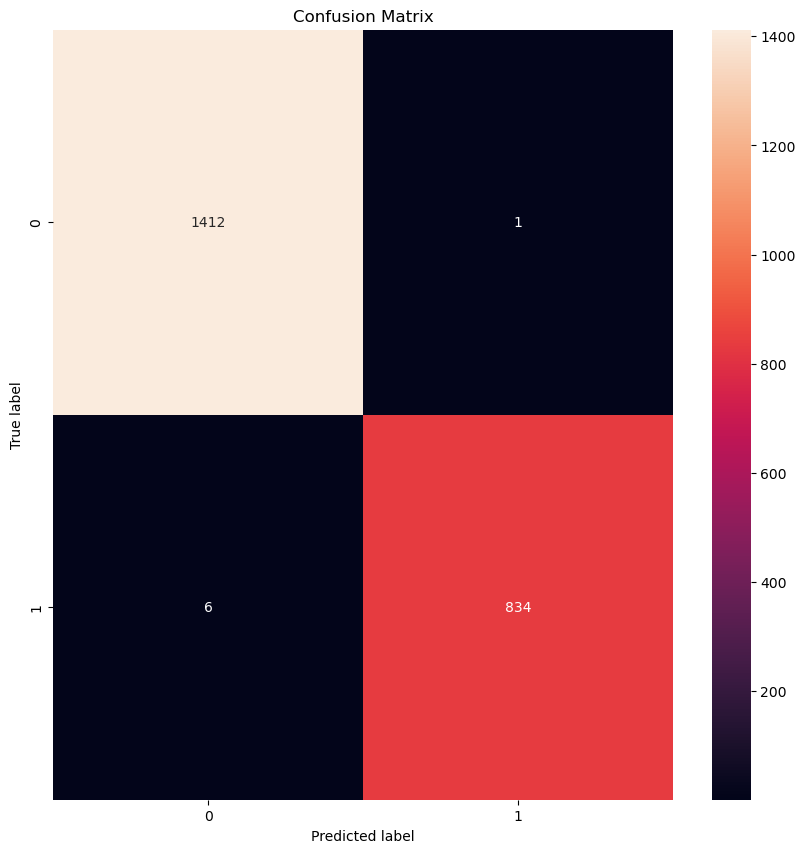

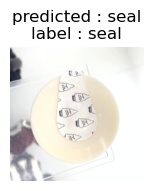

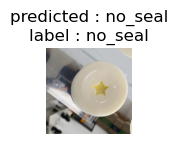

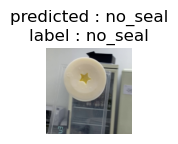

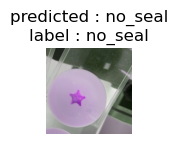

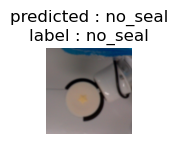

In [14]:
# best model에 대한 test 결과
model.load_state_dict(torch.load(model_name+'total_best_customfocal_1.pt'))
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total   += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (total, 100 * correct / total))

# class 별 test 결과
class_correct = list(0. for i in range(num_classes))
class_total   = list(0. for i in range(num_classes))

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

for i in range(num_classes):
    print('Accuracy of %5s : %2d %%' % (class_names[str(i)], 100 * class_correct[i] / class_total[i]))

# mAP50 and mAP50-95
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true).reshape(-1, 1)
y_pred = np.array(y_pred).reshape(-1, 1)


# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
print(cm)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# test 결과 이미지로 보기
num_show_img = 5
model.eval()
inputs, labels = next(iter(dataloaders['test']))
inputs = inputs.to(device)
labels = labels.to(device)
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(10, 10))
for i in range(num_show_img):
    ax = plt.subplot(1, num_show_img, i+1)
    ax.axis('off')
    ax.set_title('predicted : %s\nlabel : %s' % (class_names[str(int(preds[i]))], class_names[str(int(labels[i]))]))
    imshow(inputs.cpu().data[i])
plt.show()

In [17]:
# best model에 대하여, validation에서 실패한 이미지 모두 보기
num_show_img = 5
model.eval()
inputs, labels = next(iter(dataloaders['valid']))
inputs = inputs.to(device)
labels = labels.to(device)
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(10, 10))
cnt = 0
for i in range(len(labels)):
    if preds[i] != labels[i]:
        ax = plt.subplot(1, num_show_img, cnt+1)
        ax.axis('off')
        ax.set_title('predicted : %s\nlabel : %s' % (class_names[str(int(preds[i]))], class_names[str(int(labels[i]))]))
        imshow(inputs.cpu().data[i])
        cnt += 1
    if cnt == num_show_img:
        break
plt.show()

<Figure size 1000x1000 with 0 Axes>

In [16]:
# best model에 대하여, test에서 실패한 이미지 모두 보기
num_show_img = 5
model.eval()
inputs, labels = next(iter(dataloaders['test']))
inputs = inputs.to(device)
labels = labels.to(device)
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(10, 10))
cnt = 0
for i in range(len(labels)):
    if preds[i] != labels[i]:
        ax = plt.subplot(1, num_show_img, cnt+1)
        ax.axis('off')
        ax.set_title('predicted : %s\nlabel : %s' % (class_names[str(int(preds[i]))], class_names[str(int(labels[i]))]))
        imshow(inputs.cpu().data[i])
        cnt += 1
    if cnt == num_show_img:
        break
plt.show()


<Figure size 1000x1000 with 0 Axes>